#### Achilles Edwin Alfred Saxby - aes807
#### Extra_Credit_Assignment
#### Principles of Urban Informatics, Fall 2016, NYU - CUSP. 
#### Instructor: Dr. Federica Bianco

##### Worked with:
- Vishwajeet Shelar

##### Contributed to:
- Akshay Penmatcha
- Priyanshi Singh
- Patrick Gitundu
- Shalmali Kulkarni

In [13]:
import os
import ast
import urllib2
import urllib
import zipcode_run
import json
import numpy as np
import shapely
import matplotlib.pyplot as pl
import geopandas as gpd
import pandas as pd

from cStringIO import StringIO
from geopandas import GeoDataFrame
from scipy.spatial.distance import pdist, squareform

%matplotlib inline

In [2]:
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

In [3]:
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ Queries a url with an sql compatible search
    Code taken from Fbb55
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [4]:
facilityQuery = '''SELECT count(cartodb_id), zipcodes 
                  FROM NYCAsthmasDismissals 
                  GROUP BY zipcodes
                  '''

facilityStream = queryCartoDB(facilityQuery, format='JSON')

facilityData   = json.loads(facilityStream.read())
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities.columns = ['Counts','ZIPCODE']
print facilities.shape
facilities.head()

(29, 2)


,Counts,ZIPCODE
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


#### Getting the Shapefiles.
#### The Snippet of Code is in the directory itself.
#### zipcode_run.py

In [14]:
zipcode_run.getzips()

Downloading
Unzipped
Folder with required files in PUIdata, you can continue


#### Shapefile Working

In [6]:
zipfile = gpd.read_file(os.getenv("PUIDATA") + "/" + "ZIP_CODE_040114.shp")

In [7]:
zipfile.columns

Index([      u'AREA',    u'BLDGZIP',     u'COUNTY',   u'CTY_FIPS',
       u'POPULATION',    u'PO_NAME', u'SHAPE_AREA',  u'SHAPE_LEN',
            u'STATE',    u'ST_FIPS',        u'URL',    u'ZIPCODE',
         u'geometry'],
      dtype='object')

In [8]:
zipfile.shape

(263, 13)

In [9]:
zipfile.to_crs(epsg=2263, inplace=True)

In [10]:
zipfile.loc[:,'center'] = zipfile.loc[:,'geometry'].centroid

In [11]:
zipfile.drop([u'AREA',    u'BLDGZIP',     u'COUNTY',   u'CTY_FIPS',
           u'POPULATION',    u'PO_NAME', u'SHAPE_AREA',  u'SHAPE_LEN',
           u'STATE',    u'ST_FIPS',        u'URL', u'geometry'], 
          axis = 1, inplace = True)

In [12]:
zipfile.ZIPCODE = zipfile.ZIPCODE.astype('int64')
zipfile.head()

,ZIPCODE,center
0,11436,POINT (1040696.262135346 185580.2219261284)
1,11213,POINT (1001912.871996465 183803.1131541364)
2,11212,POINT (1008365.375095716 180768.9448689773)
3,11225,POINT (997023.1926918954 180870.3533321856)
4,11218,POINT (990785.2911208547 173656.0483912209)


#### Merging the Zipcodes and Dismissal Records

In [85]:
zips_facility = pd.merge(facilities, zipfile, how='inner', on='ZIPCODE')

In [86]:
zips_facility.head()

,Counts,ZIPCODE,center
0,1699,10461,POINT (1028292.72437689 247902.4282908511)
1,405,11373,POINT (1017941.215480482 208485.1046782668)
2,1698,10451,POINT (1005358.961284299 238316.0675282735)
3,220,11691,POINT (1050360.772370897 158235.4624442375)
4,246,11375,POINT (1026858.206454872 201880.2234938797)


In [87]:
krigdata = np.zeros((len(zips_facility),3))

In [88]:
for i in xrange(len(krigdata)):
    krigdata[i][0] = zips_facility.center[i].coords[0][0]
    krigdata[i][1] = zips_facility.center[i].coords[0][1]
    krigdata[i][2] = zips_facility.Counts[i]

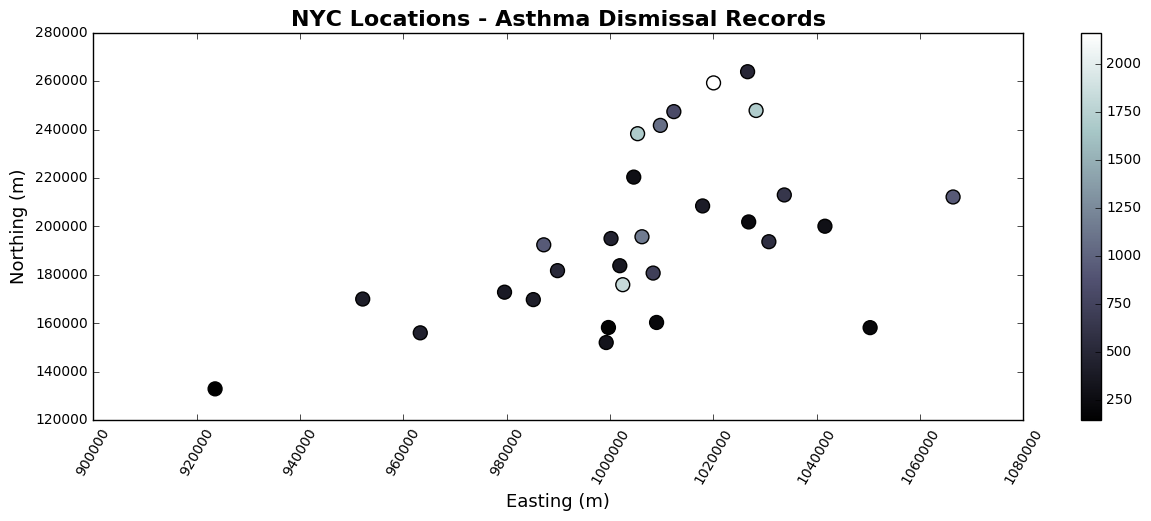

In [89]:
pl.figure(figsize=(15,5))
pl.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
pl.xlabel("Easting (m)", fontsize=13)
pl.xticks(rotation = 60)
pl.ylabel("Northing (m)", fontsize=13)
pl.title('NYC Locations - Asthma Dismissal Records', fontsize=16, fontweight = 'bold')
pl.colorbar()

#### Figure 1: The plot above shows the locations of NYC Hospitals on a Northing vs. Easting coordinate space and the Colour Density shows Asthma Dismissal Counts.

In [90]:
def SVh_vctzd( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N
    #print np.triu_indices(N)
    Z = np.zeros((N,N))
    Z = Z - P[:,2]
    #print Z
    Z = Z.T + P[:,2]
    #print Z
    Z = Z**2
    #print Z
    Zcd =  Z[(pdsv >= h - bw) * (pdsv <= h + bw) * \
            (~np.identity(N, dtype=bool))]

    #print Zcd
    return np.sum( Zcd ) / ( 2.0 * len( Zcd ) )

In [92]:
def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    #distance matrix (eucledian)
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N

    Z = list()
    for i in range(N):
        for j in range(i+1, N):
            #select only pair of points at the appropriate lag
            if( pdsv[i,j] >= h - bw )and( pdsv[i,j] <= h + bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    #print Z
    return np.sum( Z ) / ( 2.0 * len( Z ) )

In [93]:
def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        sv.append( SVh( P, h, bw ) )
        #sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T

In [94]:
lag = 400
mysv = SV( krigdata, np.arange(1, 40000, lag), 1000 )

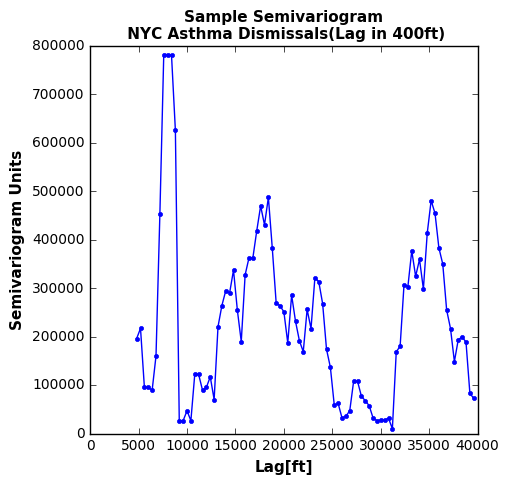

In [95]:
# lags in 500 meter increments from zero to 10,000
hs = np.arange(0, 10500, lag)
#mysv = SV( x, hs, bw )
pl.figure(figsize=(5,5))
pl.plot( mysv[0], mysv[1], '.-' )
pl.xlabel('Lag[ft]', fontsize=11, fontweight = 'bold')
pl.ylabel('Semivariogram Units', fontsize=11, fontweight = 'bold')
pl.title('Sample Semivariogram\n NYC Asthma Dismissals(Lag in %dft)'%lag, 
         fontsize=11, fontweight = 'bold') 

#### Figure 2: Semivariogram - 
    - The Lag on the X-Axis measures the distance between points.
    - The Y-Axis shows similarity in the plotted distance. 
- There is a relationship between Space and Points due to its Semi-Smooth curve. 
- There is no relationship observed between Hospitals and Asthma Dismissals.